In [58]:
import numpy as np
# %matplotlib ipympl
import matplotlib.pyplot as plt
import scipy

num_symbols = 4
samp_rate = 1_000_000 # Hz
fs = 10_000 # Hz, frequency of the sine
delta = 2*fs # Hz, frequency to add to fs at end of the symbol when chirp up
symbol_time = 0.001 # 1ms per symbol
baudrate = 1/symbol_time
sps = int(samp_rate * symbol_time)
f_shift = 100_000

print(f"{baudrate=:#}bps")
print(f"{sps=:#}sps")

m = np.array([0, 1, 0, 1])
duration = symbol_time * num_symbols # duration: time_per_symbol * n_symbols
print(f"{duration=:#}s")

msg = m.copy()
msg = msg.repeat(sps)

N = len(msg)
t = np.arange(0, duration, 1/samp_rate)
t = t[:len(m)*sps]
symbol_t = t[:sps]

baudrate=1000.0bps
sps=1000sps
duration=0.004s


In [59]:
def spectrogram(signal, filename=None):
    # Parameters
    Nfft = 512   # The number of data points used in each block for the FFT (power of 2 is better)
    noverlap = Nfft//2 # The number of points of overlap between blocks

    # Take only the first 10 symbols worth of samples
    sig = signal

    # Compute spectrogram (waterfall)
    fig, ax = plt.subplots(1, figsize=(12, 6))
    Pxx, freqs, bins, im = ax.specgram(
        sig,
        Fs=samp_rate,
        NFFT=Nfft,
        noverlap=noverlap,
        cmap="viridis",
        scale="dB",
        mode="psd",
        sides='twosided'
    )

    # Format plot to look like inspectrum (left-to-right, time on x, freq on y)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_title(f"Waterfall")

    plt.colorbar(im, ax=ax, label="Power [dB]")
    plt.tight_layout()

    if filename:
        plt.savefig(filename)

    plt.show()


def single_plot(signal, title, xlabel, ylabel, filename=None):
    fig, ax = plt.subplots(1, figsize=(10, 4))
    plt.plot(signal, '.-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    if filename:
        plt.savefig(filename)

    plt.show()


def double_plot(a, b, titlea, xlabela, ylabela, titleb, xlabelb, ylabelb, filename=None):
    fig, axes = plt.subplots(2, 1, figsize=(10, 4))  # 2 rows, 1 column

    # First subplot
    axes[0].plot(a, '.-')
    axes[0].grid(True)
    axes[0].set_title(titlea)
    axes[0].set_xlabel(xlabela)
    axes[0].set_ylabel(ylabela)

    # Second subplot
    axes[1].plot(b, '.-')
    axes[1].grid(True)
    axes[1].set_title(titleb)
    axes[1].set_xlabel(xlabelb)
    axes[1].set_ylabel(ylabelb)
    plt.tight_layout()

    if filename:
        plt.savefig(filename)

    plt.show()

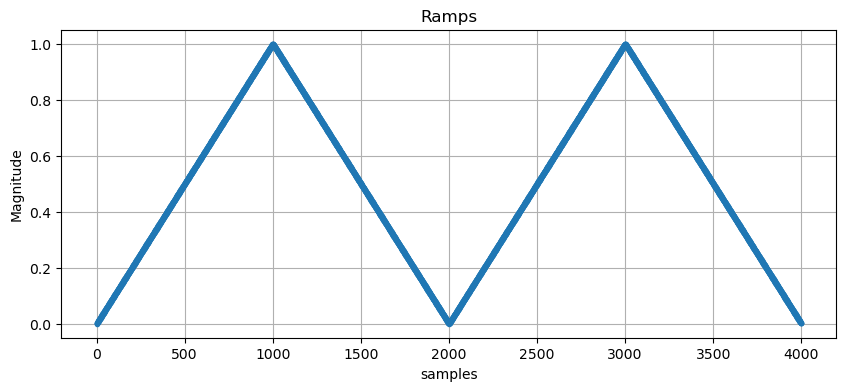

In [60]:
zero = np.arange(0, 1, 1/sps)
one = np.arange(1, 0, -1/sps)
msg = np.array([zero if x == 0 else one for x in m]).flatten()

single_plot(msg, title="Ramps", xlabel="samples", ylabel="Magnitude", filename="imgs/encode/01-ramp.png")

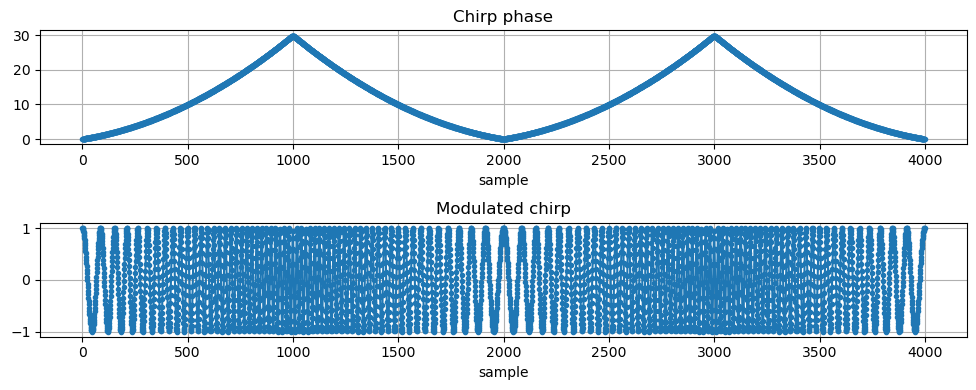

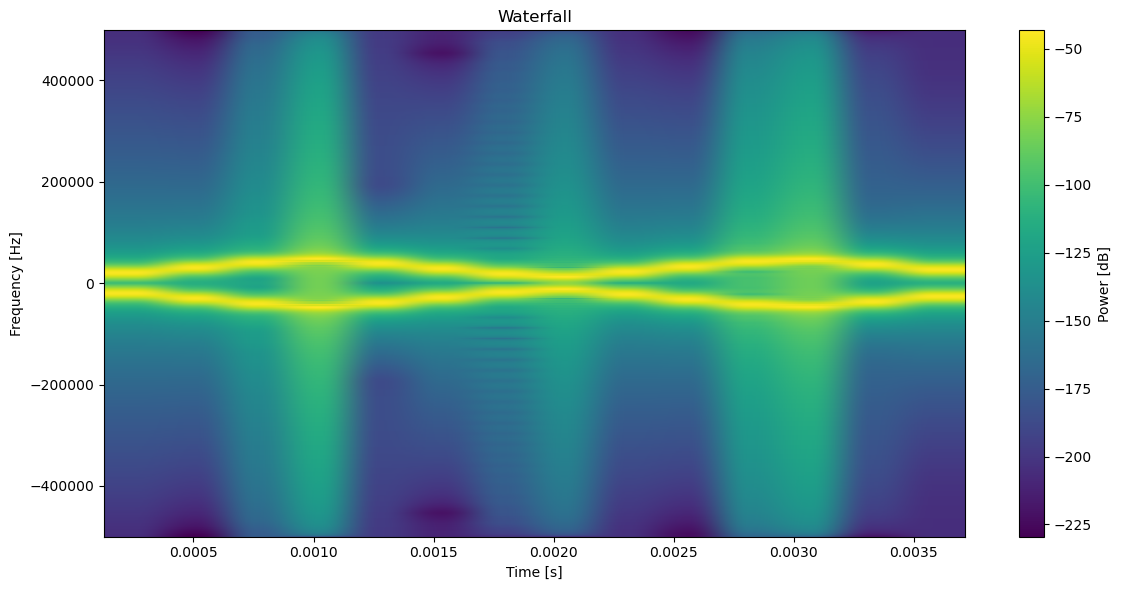

In [61]:
zero_phase = (fs + delta*zero) * symbol_t
one_phase = zero_phase[::-1]
msg = np.array([zero_phase if x == 0 else one_phase for x in m]).flatten()

phase = msg
modulated = np.cos(2 * np.pi * phase)

double_plot(phase, modulated, "Chirp phase", "sample", "", "Modulated chirp", "sample", "", filename="imgs/encode/02-chirp-phase-modulated.png")
spectrogram(modulated, filename="imgs/encode/03-chirp-spectrogram-real.png")

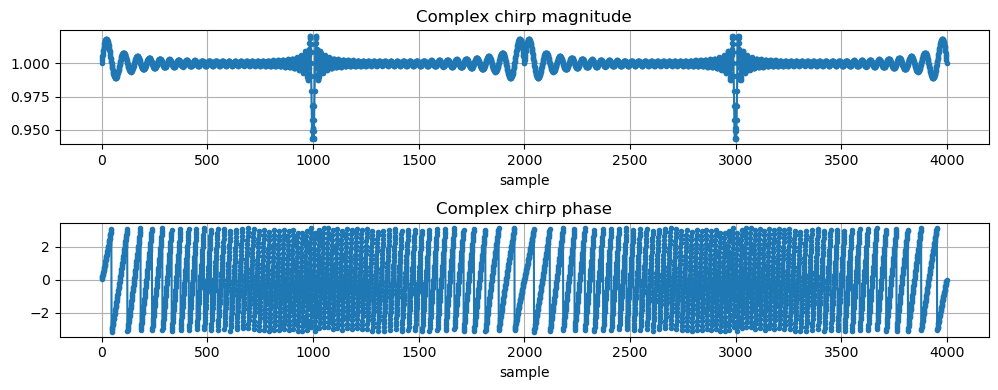

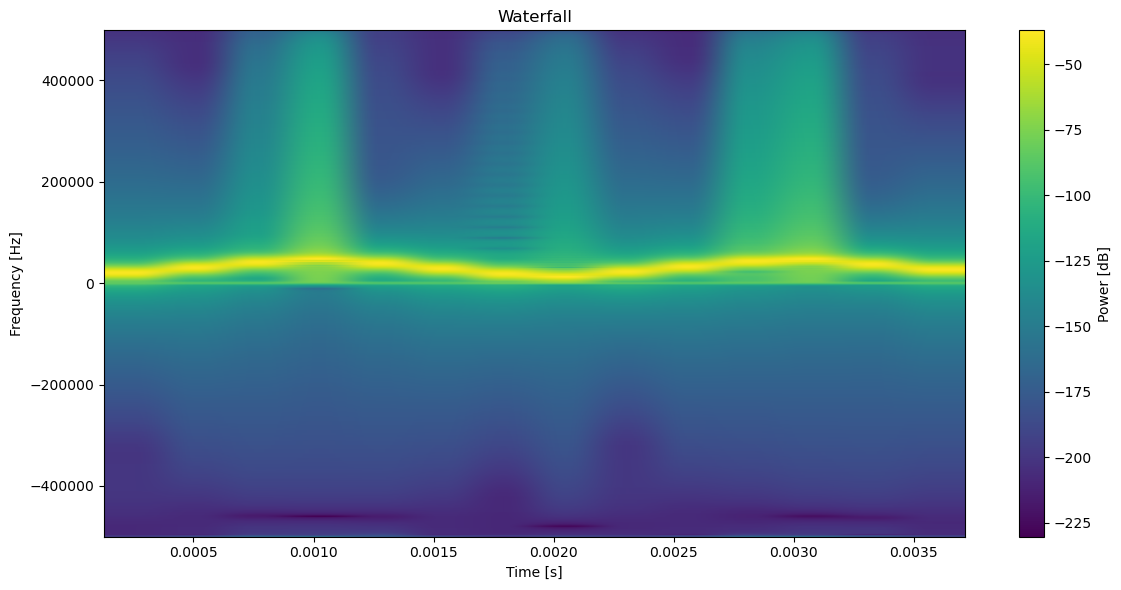

In [62]:
complex_signal = scipy.signal.hilbert(modulated)

magnitude = np.abs(complex_signal)
phase = np.angle(complex_signal)

double_plot(magnitude, phase, "Complex chirp magnitude", "sample", "", "Complex chirp phase", "sample", "", filename="imgs/encode/04-chirp-magnitude-phase-complex.png")
spectrogram(complex_signal, filename="imgs/encode/05-chirp-spectrogram-complex.png")

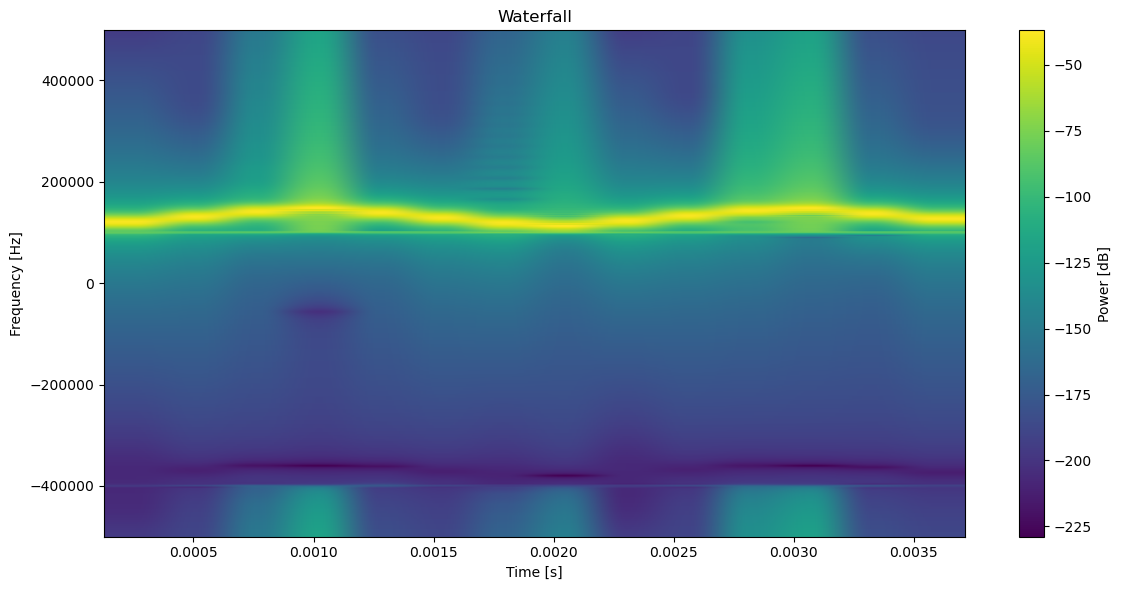

In [63]:
shifted_signal = complex_signal * np.exp(1j * 2 * np.pi * f_shift * t)

magnitude = np.abs(shifted_signal)
phase = np.angle(shifted_signal)

spectrogram(shifted_signal, filename="imgs/encode/06-shifted-spectrogram.png")

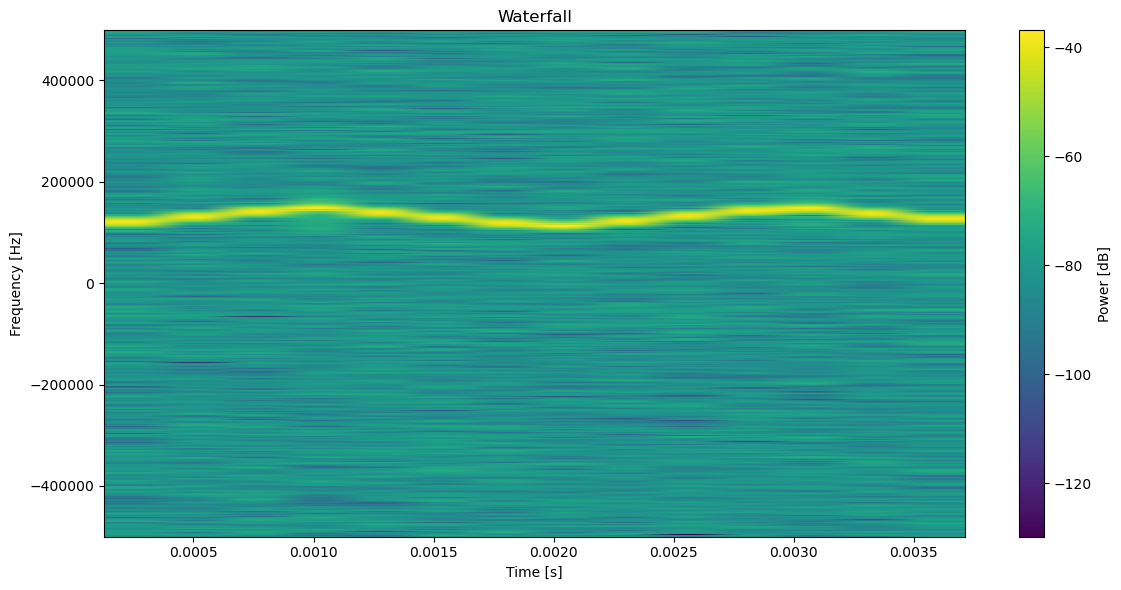

In [64]:
# Desired SNR in dB (adjust this to control noise level)
snr_db = 20  

# Compute signal power
sig_power = np.mean(np.abs(shifted_signal)**2)

# Compute noise power from SNR
snr_linear = 10**(snr_db/10)
noise_power = sig_power / snr_linear

# Generate complex Gaussian noise
noise = (np.sqrt(noise_power/2) *
         (np.random.randn(len(shifted_signal)) + 1j*np.random.randn(len(shifted_signal))))

# Add noise to the signal
noisy_signal = shifted_signal + noise

magnitude = np.abs(noisy_signal)
phase = np.angle(noisy_signal)

spectrogram(noisy_signal, filename="imgs/encode/07-noised-spectrogram.png")